# Imports

In [1]:
import os
import re
import pandas as pd
import numpy as np
from natsort import natsorted
from scipy.integrate import simpson
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from py_wake.site._site import UniformSite
from py_wake.site.shear import PowerShear
from py_wake.flow_map import Points
from py_wake import YZGrid

from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum
from py_wake.superposition_models import WeightedSum

# Turbines and site

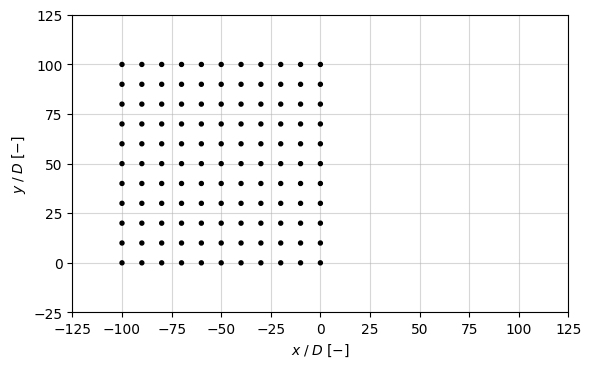

In [2]:
# --- Turbine definition ---
po = [0, 0, 0, 0, 0, 0, 0, 49, 97, 183, 268, 369, 470, 580, 722, 
      900, 1103, 1315, 1526, 1705, 1883, 1940, 1980, 1995, 2000, 
      2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 
      2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
ct = 0.8 * np.ones_like(po)
u = np.linspace(0, len(po), len(po))

turbine = WindTurbine(name='Turbines',
                      diameter=100,
                      hub_height=100,
                      powerCtFunction=PowerCtTabular(u, po, 'kW', ct))

site = UniformSite(shear=PowerShear(h_ref=turbine.hub_height(), alpha=0.1))

# --- Farm and spacing settings ---
D = turbine.diameter()
s = 10 * D  # turbine spacing

farm_width = 10000  # meters
farm_height = 10000  # meters

# Automatically compute number of rows/columns
n_cols = int(np.floor(farm_width / s)) + 1
n_rows = int(np.floor(farm_height / s)) + 1

# Generate turbine grid
x_grid, y_grid = np.meshgrid(np.arange(n_cols) * s,
                             np.arange(n_rows) * s)

x = x_grid.ravel()
y = y_grid.ravel()

# Rotate turbines if needed
theta_deg = 0
theta_rad = -np.radians(theta_deg)

rotation_matrix = np.array([
    [np.cos(theta_rad), -np.sin(theta_rad)],
    [np.sin(theta_rad),  np.cos(theta_rad)]
])

xy_rotated = rotation_matrix @ np.vstack([x, y])
x, y = xy_rotated[0], xy_rotated[1]

# Normalize origin
x = x - np.max(x)  # x=0 at downstream edge
y = y - np.min(y)  # y=0 at lowest turbine

# --- Plot ---
padding = 25  # [D]

fig, ax = plt.subplots()

for x_t, y_t in zip(x, y):
    circle = Circle((x_t/D, y_t/D), 1, color='black', fill=True)
    ax.add_patch(circle)

ax.set_xlim(min(x)/D - padding, max(x)/D + 5*padding)
ax.set_ylim(min(y)/D - padding, max(y)/D + padding)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

tick_interval = 25  # [D]
xticks = np.arange(-1000, 1000, tick_interval)
yticks = np.arange(-1000, 1000, tick_interval)

xticks = xticks[(xticks >= xlim[0]) & (xticks <= xlim[1])]
yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xlabel(r"$x \; / \; D \; [-]$")
ax.set_ylabel(r"$y \; / \; D \; [-]$")
ax.set_aspect('equal')
ax.grid(True, alpha=0.5)
ax.set_axisbelow(True)
plt.show()

# Flow map

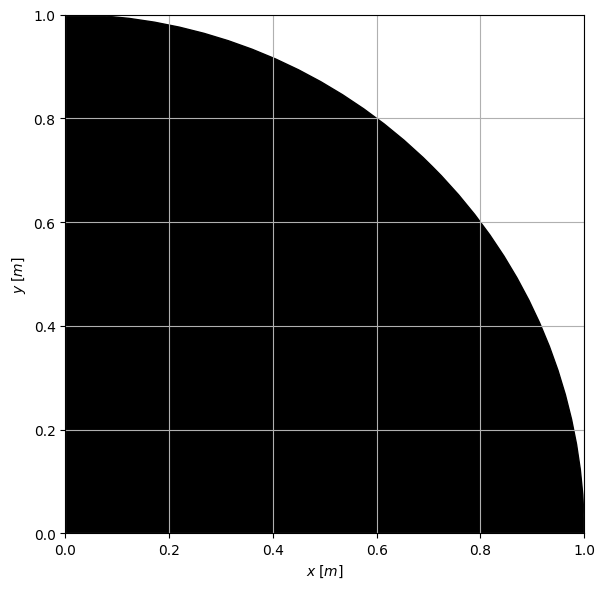

In [3]:
U_0 = 10  # [m/s]

mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(figsize=(10, 6))

wfm_l = PropagateDownwind(site, turbine,
                        wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                        superpositionModel=LinearSum())
sim_l = wfm_l(x, y, ws=U_0, wd=270, TI=0.05)

wfm_w = PropagateDownwind(site, turbine,
                        wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                        superpositionModel=WeightedSum())
sim_w = wfm_w(x, y, ws=U_0, wd=270, TI=0.05)

# ------------- Thrust of farm -------------
'''
T_values = []
C_T = 0.8
rho = 1.225
for WS_eff_ilk in np.ravel(sim.WS_eff_ilk):
    T = 1/2 * C_T * rho * np.pi*(D/2)**2 * WS_eff_ilk**2
    T_values.append(T)

print('WS_eff_ilk of a row:\n')
for ws in sim.WS_eff_ilk[:11]:
    print(ws)

print('\nThrust of a row:\n')
for t in T_values[:11]:
    print(f'{t:.0f} N')

T_total = sum(T_values)
print(f'\nT_total: {T_total/1e6:.2f} MN')

# ---------- YZ momentum integral ----------

x_Md = 100*D
y_Md = np.arange(0, farm_width+1, 10)
z_Md = np.arange(0, 200+1, 10)
yzgrid = YZGrid(x=x_Md, y=y_Md, z=z_Md)

ws_yz = sim.flow_map(yzgrid, wd=270, ws=10).WS_eff.values

#sim.flow_map(yzgrid, wd=270, ws=10).plot_wake_map()

    # Integrate here

# ------------------------------------------
'''
for x_t, y_t in zip(x, y):
    circle = Circle((x_t/D, y_t/D), radius=1, color='black', fill=True)
    ax.add_patch(circle)
    
ax.set_xlabel(r"$x \; [m]$")
ax.set_ylabel(r"$y \; [m]$")
ax.set_aspect('equal')
ax.grid(True)
plt.tight_layout()
plt.show()


# Load TDM data

In [4]:
validation_data_path = "../ArbitraryLayouts/ValidationData"

# List only files, sorted alphabetically
validation_files = natsorted(
    [f for f in os.listdir(validation_data_path) if os.path.isfile(os.path.join(validation_data_path, f))]
)

validation_datasets = {}
for file in validation_files:
    if file.endswith('.csv'):
        file_path = os.path.join(validation_data_path, file)
        validation_datasets[file] = pd.read_csv(file_path)

print("Loaded datasets:", list(validation_datasets.keys()))

Loaded datasets: ['100D.csv', '200D.csv', '600D.csv']


# Load sectioned TDM data

In [5]:
sectioned_data_path = "../ArbitraryLayouts/SectionedData"

# List only files, sorted alphabetically
section_files = natsorted(
    [f for f in os.listdir(sectioned_data_path) if os.path.isfile(os.path.join(sectioned_data_path, f))]
)

section_datasets = {}
for file in section_files:
    if file.endswith('.csv'):
        file_path = os.path.join(sectioned_data_path, file)
        section_datasets[file] = pd.read_csv(file_path)

print("Loaded datasets:", list(section_datasets.keys()))

Loaded datasets: []


# Wind speed profiles

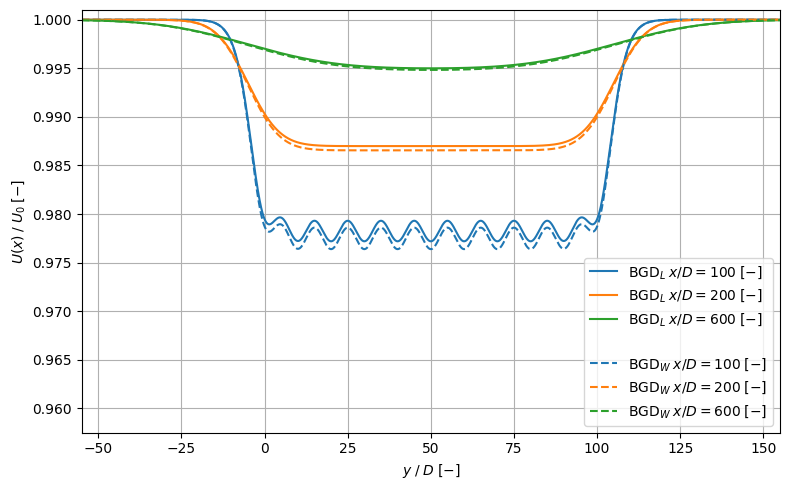

In [6]:
d_downstream = [100, 200, 600]
plot_width = 450  # in D

# Calculate number of points to match the desired spanwise resolution
y_agreed = int(plot_width * D)
y_range = None  # Will be defined once center is determined

ws_meas = {}
padded_tdm = {}
U_gauss = {}
U_gaussA = {}
tdm_lengths = {}
ftg_profiles = {}
ftg_n_solutions = {}
gauss_profiles = {}

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel(r'$y \; / \; D \; [-]$')
ax.set_ylabel(r'$ U(x) \; / \; U_0 \; [-] $')
ax.grid(True)

# --- TDM profiles (prepare first to get centering right) ---
centers = {}
for file in validation_files:
    match = re.search(r'(\d+)', file)
    d = int(match.group(1)) if match else None

    tdm_data = validation_datasets[file]
    y_col = tdm_data.iloc[:, 0].values * D  # convert from D to meters
    center = (y_col[0] + y_col[-1]) / 2
    centers[d] = center

# Define common y_range centered around each file’s true center
# We'll assume the center for the first valid distance in `d_downstream`
center_base = centers.get(d_downstream[0], 0)
y_range = np.linspace(-plot_width / 2 * D, plot_width / 2 * D, y_agreed) + center_base

# --- PyWake profiles ---
for d in d_downstream:
    m = d * D
    x_meas = np.full(y_range.shape, max(x) + m)

    ws_meas[d] = np.squeeze(
        sim_l.flow_map(Points(
            x=x_meas,
            y=y_range,
            h=turbine.hub_height() * np.ones_like(y_range)
        )).WS_eff.values)

    ax.plot(y_range / D, ws_meas[d] / U_0, label=fr'BGD$_L \; x/D={d} \; [-]$')

ax.plot([], [], linestyle='None', marker='', label=' ')

for i, d in enumerate(d_downstream):
    m = d * D
    x_meas = np.full(y_range.shape, max(x) + m)

    ws_meas[d] = np.squeeze(
        sim_w.flow_map(Points(
            x=x_meas,
            y=y_range,
            h=turbine.hub_height() * np.ones_like(y_range)
        )).WS_eff.values)
    
    color = ax.get_lines()[i].get_color()
    ax.plot(y_range / D, ws_meas[d] / U_0, linestyle='dashed', color=color, label=fr'BGD$_W \; x/D={d} \; [-]$')

#ax.plot([], [], linestyle='None', marker='', label=' ')

# --- TDM profiles ---
for i, file in enumerate(validation_files):
    match = re.search(r'(\d+)', file)
    d = int(match.group(1)) if match else None

    tdm_data = validation_datasets[file]
    y_col = tdm_data.iloc[:, 0].values * D
    tdm_values = tdm_data.iloc[:, 1].values

    if d is not None:
        tdm_lengths[d] = len(tdm_values)

        # Center the data around the shared y_range
        center = centers[d]
        y_offset = y_range - center

        # Interpolate original data to fit common y_range
        tdm_interp = np.interp(y_range, y_col, tdm_values, left=U_0 / U_0, right=U_0 / U_0)
        padded_tdm[d] = tdm_interp

        #color = ax.get_lines()[i].get_color()
        #ax.plot(y_range / D, padded_tdm[d], color=color, linestyle='--', label=f'TDM {d} D')

#ax.plot([], [], linestyle='None', marker='', label=' ')

# --- Gauss ---
rho = 1.225

for i, (d, file) in enumerate(zip(d_downstream, validation_files)):
    
    tdm_data = validation_datasets[file]
    kx = tdm_data.iloc[:, -1].values[0]

    k = kx * d*D
    '''print(f'----- {d} D -----')
    print(f'kx: {kx:.5f}  [m/m]')
    print(f'k:  {k:.0f}     [m]\n')'''

    U_TDM = padded_tdm[d] * U_0
    M_TDM = rho * simpson((U_0 - U_TDM)**2, x=y_range)

    sigma = (tdm_lengths[d]) / (2 * np.sqrt(2))

    A = np.sqrt(M_TDM / (rho * sigma * np.sqrt(np.pi)))

    U_gauss[d] = U_0 - A * np.exp(- (y_range - centers[d])**2 / (2*sigma**2))
    M_Gau = rho * simpson((U_0 - U_gauss[d])**2, x=y_range)
    
    #color = ax.get_lines()[i].get_color()
    #ax.plot(y_range / D, U_gauss[d] / U_0, linestyle=':', color=color, label=fr'TDM$_G$ {d} D')

# ax.plot([], [], linestyle='None', marker='', label=' ')

# --- TDM_sec ---
import glob
import os
import re
import pandas as pd
from collections import defaultdict
from scipy.integrate import simpson

# Directory with sectioned files
sectioned_dir = "../ArbitraryLayouts/SectionedData"
sectioned_files = glob.glob(os.path.join(sectioned_dir, "sec*-*D.csv"))

# Group sectioned files by downstream distance
sectioned_data_by_d = defaultdict(list)

for file in sectioned_files:
    match = re.search(r'sec(\d+)-(\d+)D\.csv', os.path.basename(file))
    if match:
        sec_id = int(match.group(1))
        d_val = int(match.group(2))
        sectioned_data_by_d[d_val].append((sec_id, file))

# Process each downstream distance separately
for d_val in sorted(sectioned_data_by_d):
    if d_val not in d_downstream:
        continue

    sec_files = sorted(sectioned_data_by_d[d_val], key=lambda x: x[0])  # sort by sec_id

    tdm_sec_label_added = False
    gauss_tdm_sec_label_added = False
    gaussian_components = []
    centers = {}

    for sec_id, file in sec_files:
        df = pd.read_csv(file)
        y_sec = df["y_wake"].values * D  # in meters
        U_sec = U_0 - df["U_norm"].values * U_0  # in m/s

        # Determine center for bookkeeping
        center = (y_sec[0] + y_sec[-1]) / 2
        centers[sec_id] = center

        # Pad values with U_0 outside actual range
        y_pad_left = y_range[y_range < y_sec[0]]
        y_pad_right = y_range[y_range > y_sec[-1]]

        y_plot = np.concatenate([y_pad_left, y_sec, y_pad_right])
        U_plot = np.concatenate([
            np.full_like(y_pad_left, U_0),
            U_sec,
            np.full_like(y_pad_right, U_0)
        ])

        # Uncomment to plot raw sectioned profile
        #ax.plot(y_plot / D, U_plot / U_0, linestyle='-', color='green', alpha=0.5, label='' if tdm_sec_label_added else f"TDM sections")

        if not tdm_sec_label_added:
            tdm_sec_label_added = True

        # Interpolate U_sec onto common y_range
        U_interp = np.interp(y_range, y_sec, U_sec, left=U_0, right=U_0)

        # Compute momentum deficit M_sec
        M_sec = rho * simpson((U_0 - U_interp) ** 2, x=y_range)

        # Estimate Gaussian width sigma from section width
        sigma = (y_sec[-1] - y_sec[0]) / (2 * np.sqrt(2))

        # Calculate amplitude A from M_sec
        A = np.sqrt(M_sec / (rho * sigma * np.sqrt(np.pi)))

        # Construct Gaussian velocity profile
        U_gauss_sec = A * np.exp(-(y_range - center) ** 2 / (2 * sigma ** 2))

        gaussian_components.append(U_gauss_sec)

        # Uncomment to plot individual Gaussian components
        #ax.plot(y_range / D, (U_0 - U_gauss_sec) / U_0, color='green', alpha=0.7, label='' if gauss_tdm_sec_label_added else fr"TDM$_G$ sections")

        if not gauss_tdm_sec_label_added:
            gauss_tdm_sec_label_added = True

    # --- Combine all sectioned Gaussians into a single profile ---
    if gaussian_components:
        U_combined_gauss = np.sum(gaussian_components, axis=0)

        colors = ['#1f77b4', '#ff7f0e']
        color = colors[d_downstream.index(d_val)]

        ax.plot(y_range / D, (U_0 - U_combined_gauss) / U_0, linewidth=2, linestyle=':', color=color, label=fr'TDM$_G \; x/D={d_val} \; [-]$')

ax.legend(loc='lower right')
plt.xlim(-55, 155)
plt.ylim(0.9575, 1.001)
plt.tight_layout()
plt.show()

# Momentum comparison

In [7]:
rho = 1.225

col_width = 10  # adjust this to control column width

for d in d_downstream:
    print(f"\n{f' {d} D ':=^{col_width * 3}}")

    # Hastigheder
    U_PyW = ws_meas[d]
    U_TDM = U_gauss[d]

    # Momentum
    M_PyW = rho * simpson(U_PyW**2, x=y_range)
    M_TDM = rho * simpson(U_TDM**2, x=y_range)

    # Momentumtab
    M_def_PyW = rho * simpson((U_0 - U_PyW)**2, x=y_range)
    M_def_TDM = rho * simpson((U_0 - U_TDM)**2, x=y_range)

    # Procent forskel
    M_dev = 100 * (M_TDM - M_PyW) / M_PyW
    M_def_dev = 100 * (M_def_TDM - M_def_PyW) / M_def_PyW

    # Max forskel i hastighed
    U_dev = 100 * (np.min(U_TDM) - np.min(U_PyW)) / np.min(U_PyW)

    # Print table rows
    print(f"{'M_PyW':<{col_width}} | {M_PyW:{col_width}.0f} | {'kg·m/s²':<{col_width}}")
    print(f"{'M_TDM':<{col_width}} | {M_TDM:{col_width}.0f} | {'kg·m/s²':<{col_width}}")
    print(f"{'M_dev':<{col_width}} | {M_dev:+{col_width}.2f} | {'%':<{col_width}}\n")

    print(f"{'M_def_PyW':<{col_width}} | {M_def_PyW:{col_width}.2f} | {'kg·m/s²':<{col_width}}")
    print(f"{'M_def_TDM':<{col_width}} | {M_def_TDM:{col_width}.2f} | {'kg·m/s²':<{col_width}}")
    print(f"{'M_def_dev':<{col_width}} | {M_def_dev:+{col_width}.2f} | {'%':<{col_width}}\n")

    print(f"{'U_dev':<{col_width}} | {U_dev:+{col_width}.2f} | {'%':<{col_width}}")


=========== 100 D ============
M_PyW      |    5452511 | kg·m/s²   
M_TDM      |    5290800 | kg·m/s²   
M_dev      |      -2.97 | %         

M_def_PyW  |     655.08 | kg·m/s²   
M_def_TDM  |    3208.02 | kg·m/s²   
M_def_dev  |    +389.71 | %         

U_dev      |      -1.65 | %         

=========== 200 D ============
M_PyW      |    5476498 | kg·m/s²   
M_TDM      |    5378566 | kg·m/s²   
M_dev      |      -1.79 | %         

M_def_PyW  |     224.01 | kg·m/s²   
M_def_TDM  |    1084.76 | kg·m/s²   
M_def_dev  |    +384.24 | %         

U_dev      |      -0.88 | %         

=========== 600 D ============
M_PyW      |    5498471 | kg·m/s²   
M_TDM      |    5461053 | kg·m/s²   
M_dev      |      -0.68 | %         

M_def_PyW  |      28.70 | kg·m/s²   
M_def_TDM  |     147.38 | kg·m/s²   
M_def_dev  |    +413.47 | %         

U_dev      |      -0.26 | %         


# Momentum

In [8]:
for d, file in zip(d_downstream, validation_files):

    tdm_data = validation_datasets[file]
    k = tdm_data.iloc[:, -1].values[0]

    U_PyW = ws_meas[d]
    M_PyW = rho * simpson((U_0 - U_PyW)**2, x=y_range)

    U_TDM = padded_tdm[d] * U_0
    M_TDM = rho * simpson((U_0 - U_TDM)**2, x=y_range)

    U_Gau = U_gauss[d]
    M_Gau = rho * simpson((U_0 - U_Gau)**2, x=y_range)

    print('\nM_PyW:', round(M_PyW,2))
    #print('M_TDM:', M_TDM)
    print('M_Gau:', round(M_Gau,2))
    print(f'k({d}): {k:.0e}')


M_PyW: 655.08
M_Gau: 3208.02
k(100): 8e-01

M_PyW: 224.01
M_Gau: 1084.76
k(200): 5e-01

M_PyW: 28.7
M_Gau: 147.38
k(600): 2e-01


# Forhold mellem maks og gns. hastighed (PyWake)

In [9]:
def_mean_mean = 0

for d in d_downstream:

    def_mean = np.mean(U_0-ws_meas[d])
    def_max = np.max(U_0-ws_meas[d])

    print('\nU_def_gns:', def_mean)
    print('U_def_min:', def_max)
    print('max/mean:', def_max / def_mean)

    def_mean_mean +=  def_max / def_mean

def_mean_mean = def_mean_mean/3
print('\ndef_mean_mean:', def_mean_mean)


U_def_gns: 0.05500434747710963
U_def_min: 0.23607429744448716
max/mean: 4.291920698499892

U_def_gns: 0.032857533283731866
U_def_min: 0.1344255439307087
max/mean: 4.091163593137538

U_def_gns: 0.012750203100252315
U_def_min: 0.05165298720432254
max/mean: 4.051150150172932

def_mean_mean: 4.1447448139367875
